# DeepDeWedge Tutorial

This is a minimal example for how to apply DeepDeWedge.

In [13]:
import math
from matplotlib import pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import torch

from pytorch_lightning import seed_everything

from src.masked_loss import masked_loss
from src.normalization import get_avg_model_input_mean_and_var
from src.refine_tomogram import refine_tomogram
from src.setup_dataset import setup_fitting_and_val_dataset
from src.unet import Unet3D
from src.utils.mrctools import load_mrc_data
from src.utils.visualization import plot_tomo_slices
from src.utils.dataloader import MultiEpochsDataLoader


seed_everything(42)

Global seed set to 42


42

## Download the tutorial dataset
We apply DeepDeWedge to a tilt series collected from Chlamydomonas Reinhardtii. The tilt series is part of the Tomo110 dataset ([which can be downloaded here](https://download.fht.org/jug/cryoCARE/Tomo110.zip)), which was used in the tutorial for the [CryoCARE](https://github.com/juglab/cryoCARE_T2T) denoising method. First, we download the tutorial dataset which contains FBP reconstructions from the full and splitted tilt series. For FBP reconstruction, we follwed the [CryoCARE tutorial](https://github.com/juglab/cryoCARE_T2T/tree/master/example). The tilt series are splitted using the frame-based approach.

In [16]:
# download data with wget
!wget https://figshare.com/ndownloader/files/44184638?private_link=5a5e8c76eb5d7430d379 -O tutorial_data.zip
!unzip tutorial_data.zip
!rm tutorial_data.zip

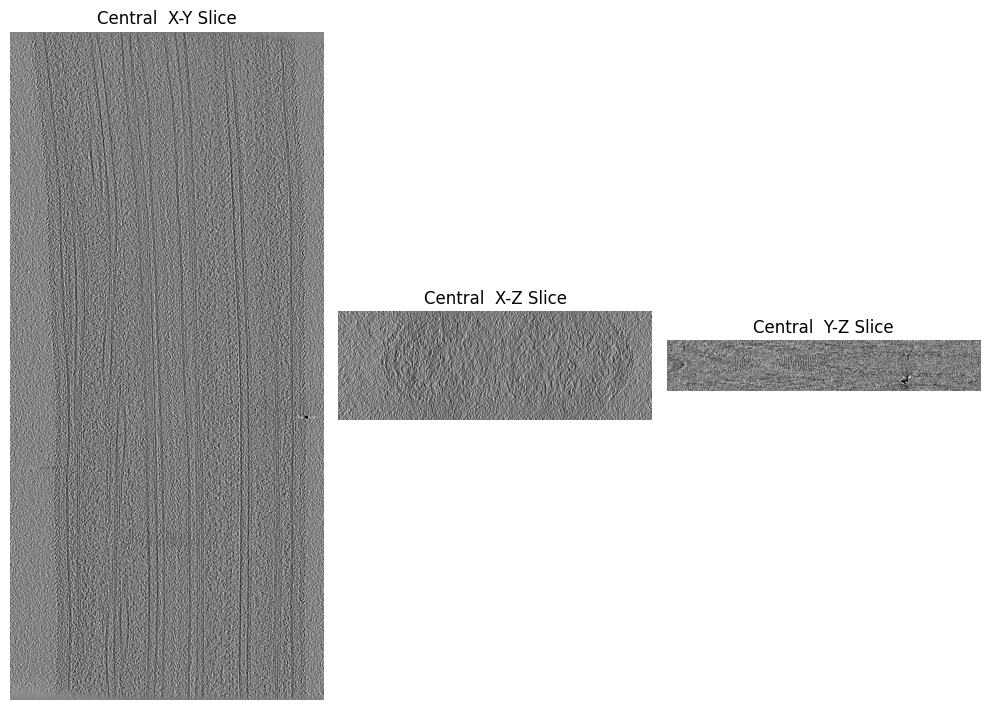

In [15]:
tomo_full = load_mrc_data("./tutorial_data/tomo_full.mrc")
plot_tomo_slices(
    tomo_full.clamp(-3 * tomo_full.std(), 3 * tomo_full.std()), figsize=(10, 20)
).show()


## Setup datasets for model fitting
We first load the dataset for model fitting. The function `setup_fitting_and_val_dataset` returns two torch datasets, one for model fitting and one for validation to prevent overfitting. The tomograms corresponding to the filepaths in `tomo0_files` are used to construct the model inputs, while the ones in `tomo1_files` are used to construct the targets. 

Both the fitting and the validation dataset return model inputs and targets with shape `subtomo_size x subtomo_size x subtomo_size`. These subtomograms are extracted from the tomograms using x, y and z direction strides specified in `subtomo_extraction_strides`. To reduce RAM consumption during model fitting, all subtomograms are saved to the directory `save_subtomos_to`, which is created if it doe note exist.

The number of elements in the validation set is at most `validation_frac` times the number of total extracted subtomograms. It may also contain fewer subtomograms since we randomly sample the validation subtomograms such that they have no overlap with the ones used for model fitting. If the sampling procedure was unable to sample enough validation subtomograms, the function prints a warning.

In [4]:
fitting_dataset, val_dataset = setup_fitting_and_val_dataset(
    tomo0_files=["./tutorial_data/tomo_even_frames.mrc"],
    tomo1_files=["./tutorial_data/tomo_odd_frames.mrc"],
    subtomo_size=96,
    subtomo_extraction_strides=[32, 96, 96],  # reducing the stride lengths increases the number of subtomos
    mw_angle=60,  # the width of the missing wedge
    val_fraction=0.20,
    save_subtomos_to="./subtomos/",
)

print(f"Number of subtomos for model fitting: {len(fitting_dataset)}")
print(f"Number of subtomos for validation: {len(val_dataset)}")


Number of subtomos for model fitting: 144
Number of subtomos for validation: 36


Both the fitting and the validation dataset return dictionries containing the following items:
* `model_input`: A model input $\tilde{\mathbf{v}}_\varphi^0$ with two missing wedges
* `model_target`: A model target $\tilde{\mathbf{v}}_\varphi^1$ with only one missing wedge
* `rot_mw_mask`: The rotated missing wedge mask $\mathbf{M}_\varphi$
* `mw_mask`: The original missing wedge mask $\mathbf{M}$. This mask is the same for all elements in the dataset.

**Note**: The rotation angles $\varphi$ in the training set are always random, and are re-sampled every time an item is queried. For the validation dataset, we only sample random rotation angles once and every item always has its fixed rotation.


Let's now have a look at the real and Fourier domain representation of some of the model inputs:

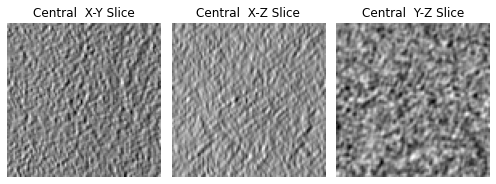

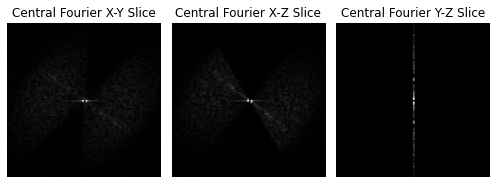

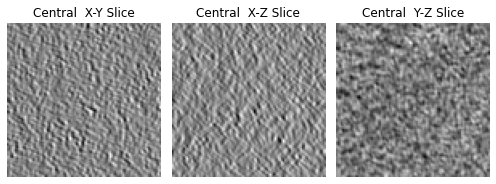

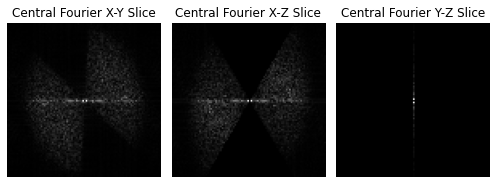

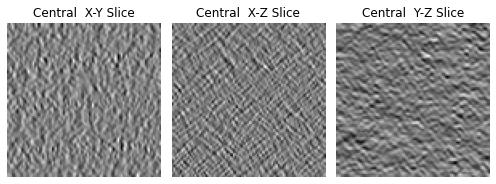

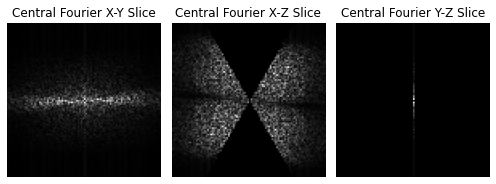

In [5]:
for k in range(3):
    item = fitting_dataset[k]
    model_input = item["model_input"]
    model_input -= model_input.mean()
    plot_tomo_slices(item["model_input"], domain="image").show()
    plot_tomo_slices(item["model_input"], domain="fourier").show()


We create a fitting and a validation dataloader which return batches of elements from the fitting and validation sets:

In [6]:
batch_size = 5  # you may have to reduce the batch size if your GPU runs out of memory
num_workers = 10  # more workers enable faster data loading but use more CPU resources

fitting_dataloader = MultiEpochsDataLoader(
    dataset=fitting_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
)
val_dataloader = MultiEpochsDataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=True,
)


## Fit the model

First, we setup a 3D U-Net. The architecture we implemented in `unet.py` is the same used in the official [IsoNet](https://github.com/IsoNet-cryoET/IsoNet) implementation, which we also used in our paper.
Before we can start model fitting, we calculate the average mean and variance of the model inputs in the fitting dataset. We use these values to normalize the input to the U-Net during model fitting.

In [8]:
unet_params = {
    "in_chans": 1,
    "out_chans": 1,
    "chans": 64,
    "num_downsample_layers": 3,
    "drop_prob": 0.0,
}

avg_model_input_mean, avg_model_input_var = get_avg_model_input_mean_and_var(
    fitting_dataloader,
    batches=3*len(fitting_dataloader),  # compute mean and variance of the model inputs using three passes through the entire dataset
    verbose=True,
)
unet_params["normalization_loc"] = avg_model_input_mean
unet_params["normalization_scale"] = math.sqrt(avg_model_input_var)


Getting average model input mean and variance: 100%|██████████| 87/87 [01:24<00:00,  1.02it/s]


Average model input mean: -0.1469729095697403 (Variance over inputs: 0.0065350644290447235)
Average model input varariance: 1.5543733835220337 (Variance over inputs: 0.09168963879346848)


For conventient model fitting, we use the [PyTorch lightning](https://lightning.ai/pytorch-lightning/) framework. Below, we define the class `LitUnet3D`, which takes parameters for a U-Net and the `torch.optim.Adam` optimizer as input and can then be used to fit the U-Net using PyTroch lightning. The two most important methods of this class are:
* `training_step`: This step handles passing the model inputs provided by the fitting dataloader through the model and calculating the loss. 
+ `validation_step`: In this step, we can implement any validation routine we like. For simplicity, we just calculate the loss on the validation set to monitor overfitting. Depending on which logger we use, we can for example also log plots of the model output.

In [17]:
class LitUnet3D(pl.LightningModule):
    def __init__(self, unet_params, adam_params):
        super().__init__()
        self.unet_params = unet_params
        self.adam_params = adam_params
        self.unet = Unet3D(**self.unet_params)
        self.save_hyperparameters()

    def forward(self, x):
        return self.unet(x.unsqueeze(1)).squeeze(1)  # unsqueeze to add channel dimension, squeeze to remove it

    def training_step(self, batch, batch_idx):
        model_output = self(batch["model_input"])
        loss = masked_loss(
            model_output=model_output,
            target=batch["model_target"],
            rot_mw_mask=batch["rot_mw_mask"],
            mw_mask=batch["mw_mask"],
        )
        self.log(
            "train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        model_output = self(batch["model_input"])
        loss = masked_loss(
            model_output=model_output,
            target=batch["model_target"],
            rot_mw_mask=batch["rot_mw_mask"],
            mw_mask=batch["mw_mask"],
        )
        self.log(
            "val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), **self.adam_params)
        return optimizer


PyTorch Lightning's ``Trainer`` will do the heavy lifting for us. In this tutorial, we only specify the bare minimum of parameters such as the number of epochs for model fitting `max_epochs`, the GPU used for fitting, and some logging and model checkpointing functionality (callbacks). For more advanced functionality, please refer to the [documentation](https://lightning.ai/docs/pytorch/stable/common/trainer.html) of the ``Trainer`` class.

In [ ]:
# setup a logger that logs the metrics (train_loss, val_loss) we specified above
logger =pl.loggers.CSVLogger("csv_logs", name="tutorial") # this logger creates a folder "csv_logs" and saves all logs as csv files there
# logger=pl.loggers.TensorBoardLogger("tensorboard_logs", name="tutorial_tomo110"),  # the TensorBoard logger offers more functionality than the CSVLogger,
logdir = f"{logger.save_dir}/{logger.name}/version_{logger.version}"
print(f"Saving logs and model checkpoints to '{logdir}'")

# this saves the model everey 50 epochs
epoch_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f"{logdir}/checkpoints/epoch", 
    filename='{epoch}', 
    monitor="epoch", 
    verbose=True,
    save_top_k=-1,
    every_n_epochs=50, 
)
# this saves the top 3 models with the lowest validation loss
val_loss_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f"{logdir}/checkpoints/val_loss", 
    filename='{epoch}-{val_loss:.5f}', 
    monitor="val_loss", 
    verbose=True,
    save_top_k=3,
)

# initialize the model
lit_unet = LitUnet3D(unet_params=unet_params, adam_params={"lr": 4e-4})

# initialize the trainer
trainer = pl.Trainer(
    max_epochs=1000,  # fitting for 1000 epochs may take a long time depending on your hardware; 300 epochs should already give you a good resut
    accelerator="gpu",
    devices=[0],
    check_val_every_n_epoch=1,
    deterministic=True,  # to ensure reproducability
    logger=logger,  
    callbacks=[epoch_callback, val_loss_callback]
)

trainer.fit(lit_unet, fitting_dataloader, val_dataloader)

Now we plot the training and validation loss curves from the ``.csv`` file produced by the ``CSVLogger``. Although the validation loss is still decreasing, the visual quality of the reconstruction is already quite good and does not change much anymore, so we do not fit for more epochs.

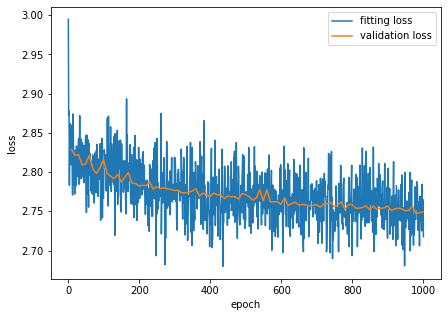

In [18]:
metrics = pd.read_csv(f"{logdir}/metrics.csv")

plt.figure(figsize=(7,5))
plt.plot(metrics[~metrics.train_loss.isna()].epoch, metrics.train_loss[~metrics.train_loss.isna()], label="fitting loss")
plt.plot(metrics[~metrics.val_loss.isna()].epoch, metrics.val_loss[~metrics.val_loss.isna()], label="validation loss")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="best")

## Refine the full FBP reconstruction

We now apply the fitted model to the full FBP reconstruction. 

Processing subtomos: 100%|██████████| 54/54 [00:47<00:00,  1.13it/s]


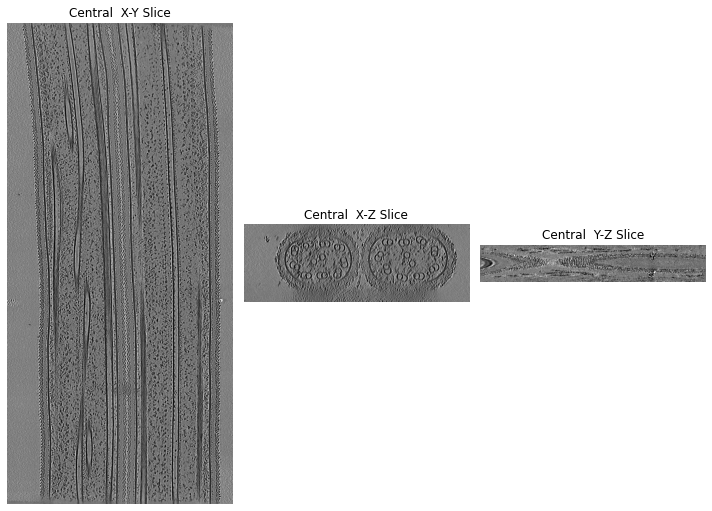

In [20]:
# we load a model that we fitted for 1000 epochs, comment this out if you want to use the model you just trained
lit_unet = LitUnet3D.load_from_checkpoint("./tutorial_data/fitted_model.ckpt").to("cuda:0")

tomo_ref = refine_tomogram(
    tomo=tomo_full,
    lightning_model=lit_unet.to(lit_unet.device),
    subtomo_size=96,  # this should be the same as the subtomo_size used for the model fitting
    subtomo_extraction_strides=[64, 64, 64],  # this can differ from the subtomo_extraction_strides used for the model fitting; reduce the stride lengths if you observe artifacts in the refined tomogram
    batch_size=10,
)
tomo_ref = tomo_ref.cpu()
plot_tomo_slices(
    tomo_ref.clamp(-3 * tomo_ref.std(), 3 * tomo_ref.std()), figsize=(10, 15)
).show()